In [ ]:
import os
import sys
import io
import gzip
import zipfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.io import mmread

def load_graph(name: str) -> nx.Graph:
    """ネットワークグラフをダウンロードして初期化する関数

    パラメータ
    ----------
    name : str
        次のいずれかを指定する: ["cora",  "football", "arvix", "power-us-grid", "facebook", "wiki"]

    戻り値
    -------
    nx.Graph

    例外
    ------
    ValueError
        指定された名前がサポートされていない場合
    """
    if name.lower() == "cora":
        # Cora データセット（GraphML形式）をダウンロードして読み込む
        download_url = "https://temprl.com/cora.graphml"
        res = requests.get(download_url)
        G = nx.read_graphml(io.BytesIO(res.content))
        G = nx.to_undirected(G)
        return G


    elif name.lower() == "football":
        # アメリカンフットボールのネットワークデータを読み込む
        download_url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

        res = requests.get(download_url)
        s = io.BytesIO(res.content)

        zf = zipfile.ZipFile(s)
        txt = zf.read("football.txt").decode()
        gml = zf.read("football.gml").decode()
        gml = gml.split("\n")[1:]  # コメント行を除去
        G_football = nx.parse_gml(gml)
        G_football = nx.relabel_nodes(
            G_football,
            {k: v for k, v in zip(G_football.nodes, range(len(G_football.nodes)))},
        )
        return G_football

    elif name.lower() == "power-us-grid":
        # アメリカの電力網ネットワークを読み込む（疎行列形式）
        download_url = "https://nrvis.com/download/data/power/power-US-Grid.zip"
        res = requests.get(download_url)
        zf = zipfile.ZipFile(io.BytesIO(res.content))
        G = nx.from_scipy_sparse_array(mmread(zf.open("power-US-Grid.mtx")))
        node_map = {u: int(u) for u in G.nodes}
        G = nx.relabel_nodes(G, node_map, copy=True)
        return G

    elif name.lower() in ["wiki", "arvix", "facebook"]:
        # SNAPデータセット（GZIP形式）を読み込む
        if name.lower() == "wiki":
            download_url = "https://snap.stanford.edu/data/wiki-Vote.txt.gz"
        elif name.lower() == "arvix":
            download_url = "https://snap.stanford.edu/data/ca-GrQc.txt.gz"
        elif name.lower() == "facebook":
            download_url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"

        res = requests.get(download_url)
        with gzip.open(io.BytesIO(res.content), "rb") as f:
            G = nx.read_edgelist(f)
        return G

    else:
        raise ValueError("指定されたグラフは見つかりません")


# ネットワーク

 $G = (V,E)$  
 $V$ = graph components: nodes, vertices $u \in V$  
 $E$ = graph interactions: links, edges

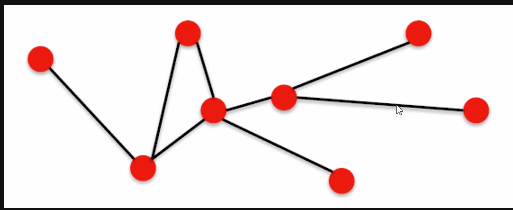


In [15]:
# Download and load graphs.
G_pgrid = load_graph("power-us-grid")
G_arvix = load_graph("arvix")
G_fb = load_graph("facebook")
G_wiki = load_graph("wiki")
G_cora = load_graph("cora")

In [21]:
print("power grid: ", G_pgrid)
print("Arvix collaboration network: ", G_arvix)
print("Facebook: ", G_fb)
print("Wiki Vote: ", G_wiki)
print("Cora: ", G_cora)

power grid:  Graph with 4941 nodes and 6594 edges
Arvix collaboration network:  Graph with 5242 nodes and 14496 edges
Facebook:  Graph with 4039 nodes and 88234 edges
Wiki Vote:  Graph with 7115 nodes and 100762 edges
Cora:  Graph with 2485 nodes and 5069 edges


# 密度とスパース性

## 最大エッジ数

ネットワークのリンク数の上限は、ネットワーク内のノード間で可能な個々の繋がりの数によって制限される。従って、リンクの最大数はノードのペア数で決まる。

ノード数 $N$ の**無向ネットワーク**において、可能なエッジ（リンク）の最大数は次の式で与えられます：

$$
E_{\text{max}} = \dfrac{N(N-1)}{2}
$$

直感的には、各ノードは他の$N-1$個のノードと接続することができ、その数は$N$個である。しかしその場合、各ペアを二重に数えていることになるので、2で割る。

ネットワーク内のすべてのノードが互いに直接リンクしているネットワークは完全ネットワーク（Complete Network）で呼ぶ。

True


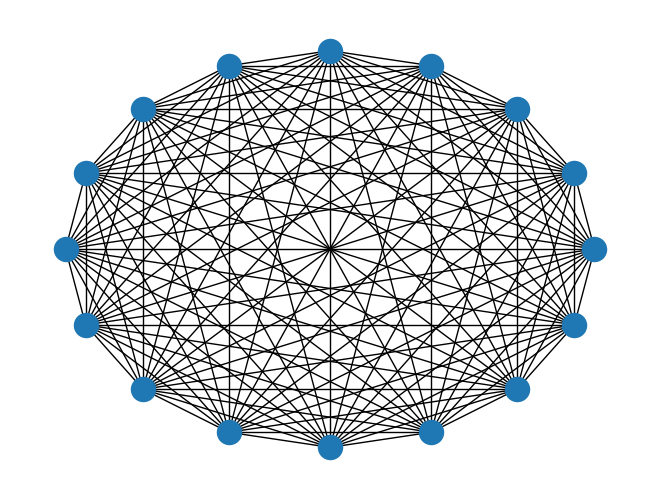

In [69]:
G = nx.complete_graph(n=16)
nx.draw_circular(G)

print(len(G.edges) == len(G.nodes) * (len(G.nodes) - 1) / 2)

## 密度

**ネットワークの密度**とは、ネットワークにおいて、実際に存在するエッジの数が、理論上可能な最大数のエッジに対してどれだけの割合を占めているかを表す指標です。

完全ネットワークの密度は最大値の1になる。しかしながら、現実世界のネットワークでは、ほとんどのノードのペアは互いに直接接続されていないため、実際のリンク数は最大数よりはるかに
小さいのが一般です。

従って、現実世界の大規模なネットワークでは、密度は1より小さいことが多い。これはネットワーク構造を扱う上で重要な特徴であるスパース性(sparsity)と呼ばれている。

---

ノード数を $N$、実際のエッジ数を $E$ とすると、密度 $D$ は次のように定義されます：

$$
D = \dfrac{2E}{N(N - 1)}
$$

- 分母 $N(N-1)/2$ は、無向ネットワークにおける **最大エッジ数**（完全ネットワークのエッジ数）です。
- 値の範囲は $0 \leq D \leq 1$：
  - $D = 1$ のとき、完全ネットワーク（すべてのノードが接続）です。
  - $D = 0$ のとき、エッジが1本もない状態です。

---

### 🔷 定義（有向ネットワークの場合）

有向ネットワーク（自己ループなし）の場合、最大エッジ数は $N(N-1)$ となるため、密度は次のように定義されます：

$$
D = \dfrac{E}{N(N - 1)}
$$

---

- **密度が高い**ほど、ノード間の接続が密で、情報伝播や影響力の広がりが速い傾向があります。
- **密度が低い**ネットワークでは、構造がスパース（まばら）で、コミュニティ構造やネットワーク分断が発生しやすくなります。


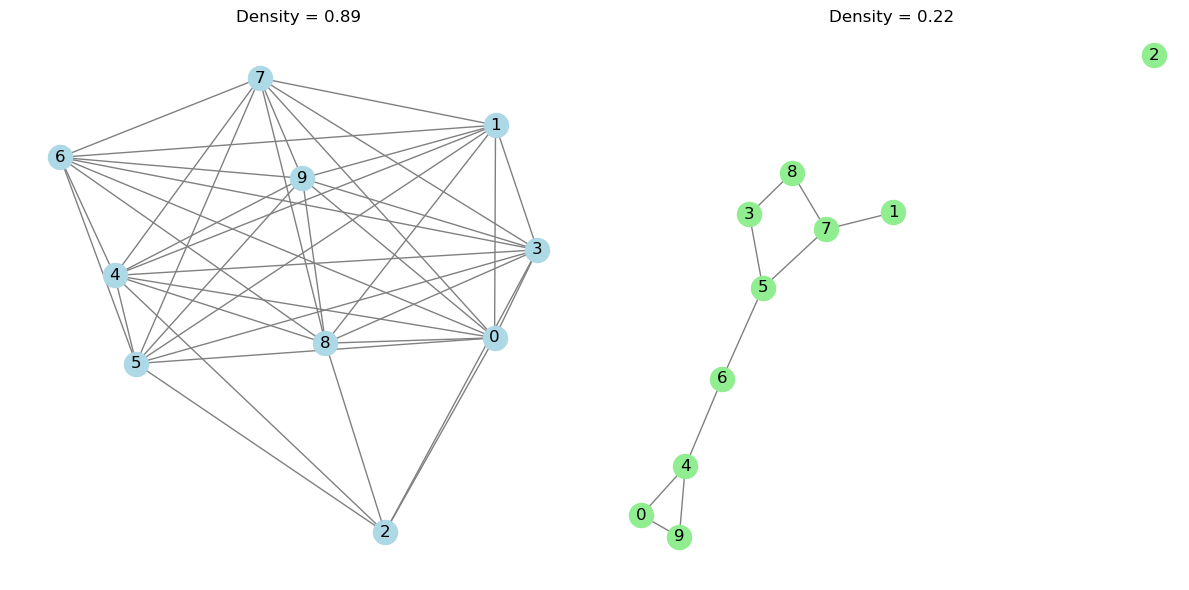

In [71]:
# 高密度ネットワーク（ほぼ完全グラフに近い）
dense_graph = nx.dense_gnm_random_graph(n=10, m=40)  # ノード10個、エッジ40本

# 低密度ネットワーク（スパースな構造）
sparse_graph = nx.gnm_random_graph(n=10, m=10)  # ノード10個、エッジ10本

# 図の描画
plt.figure(figsize=(12, 6))

# 高密度ネットワークの描画
plt.subplot(1, 2, 1)
nx.draw(dense_graph, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Density = {:.2f}".format(nx.density(dense_graph)))

# 低密度ネットワークの描画
plt.subplot(1, 2, 2)
nx.draw(sparse_graph, with_labels=True, node_color='lightgreen', edge_color='gray')
plt.title("Density = {:.2f}".format(nx.density(sparse_graph)))

plt.tight_layout()
plt.show()

In [72]:
def graph_stats(G, name):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)
    print(f"{name}:")
    print(f"  ノード数: {n}")
    print(f"  エッジ数: {m}")
    print(f"  密度: {density:.6f}\n")

graph_stats(G_pgrid, "power-us-grid")
graph_stats(G_arvix, "arvix")
graph_stats(G_fb, "facebook")
graph_stats(G_wiki, "wiki")
graph_stats(G_cora, "cora")

power-us-grid:
  ノード数: 4941
  エッジ数: 6594
  密度: 0.000540

arvix:
  ノード数: 5242
  エッジ数: 14496
  密度: 0.001055

facebook:
  ノード数: 4039
  エッジ数: 88234
  密度: 0.010820

wiki:
  ノード数: 7115
  エッジ数: 100762
  密度: 0.003981

cora:
  ノード数: 2485
  エッジ数: 5069
  密度: 0.001642



# 次数


あるノードが接続しているリンク（辺）の数を**次数**（degree）と呼びます。



---

## **平均次数**

ネットワーク全体におけるノードの次数の平均値を**平均次数**といいます：

$$
\langle k \rangle \equiv \dfrac{1}{N} \sum_{i=1}^{N} k_i
$$

---

### **無向グラフの場合**

無向ネットワークでは、平均次数は次のように表されます：

$$
\langle k \rangle \equiv \dfrac{2E}{N}
$$

ここで $E$ はネットワーク内のリンク（辺）の総数です。

---

### **有向グラフの場合**

有向ネットワークでは、各ノードには**入次数**と**出次数**があります：

- 平均入次数：

  $$
  \langle k^{\text{in}} \rangle \equiv \dfrac{1}{N} \sum_{i=1}^{N} k_i^{\text{in}} = \dfrac{E}{N}
  $$

- 平均出次数：

  $$
  \langle k^{\text{out}} \rangle \equiv \dfrac{1}{N} \sum_{i=1}^{N} k_i^{\text{out}}
  $$

※ 有向グラフでもリンク数 $E$ に対し、入次数と出次数の合計は同じなので：

$$
\langle k \rangle \equiv \dfrac{E}{N}
$$

### ノードの次数分布（Node degree distribution）

次のように定義します：

- $N_k$：次数が $k$ であるノードの数  
- $P(k)$：ランダムに選ばれたノードの次数が $k$ である確率

> このとき、次数分布は次のように表されます：

$$
P(k) = \dfrac{N_k}{N}
$$

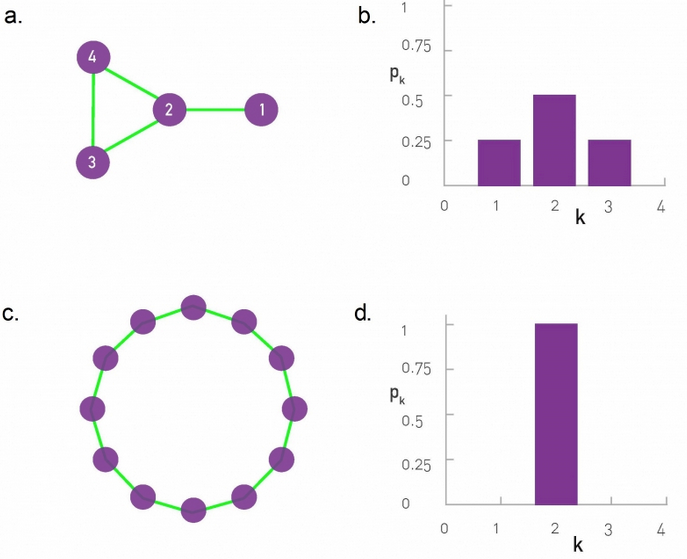


In [ ]:
def average_degree(G: nx.Graph) -> float:
    return sum(G.degree(n) for n in G.nodes) / len(G.nodes)

def average_in(G: nx.Graph) -> float:
    return sum(G.in_degree(n) for n in G.nodes) / len(G.nodes)

def average_out(G: nx.Graph) -> float:
    return sum(G.out_degree(n) for n in G.nodes) / len(G.nodes)

In [66]:
print(average_degree(G_pgrid))
print(average_degree(G_arvix))
print(average_degree(G_fb))
print(average_degree(G_wiki))
print(average_degree(G_cora))

2.66909532483303
5.530713468141931
43.69101262688784
28.32382290934645
4.0796780684104625


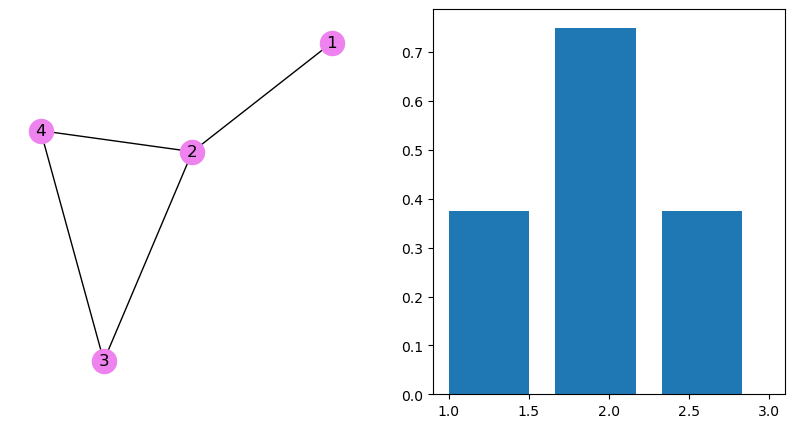

In [67]:
G = nx.cycle_graph(12)
G = nx.Graph([(1, 2), (2, 4), (2, 3), (3, 4)])


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot graph
nx.draw_kamada_kawai(G, with_labels=True, node_color="violet", ax=axs[0])

# Plot hist
# plt.subplot(2, 2, 2)
axs[1].hist([G.degree(n) for n in G.nodes], density=True, bins=3, width=0.5)
plt.show()

<Figure size 2000x500 with 0 Axes>

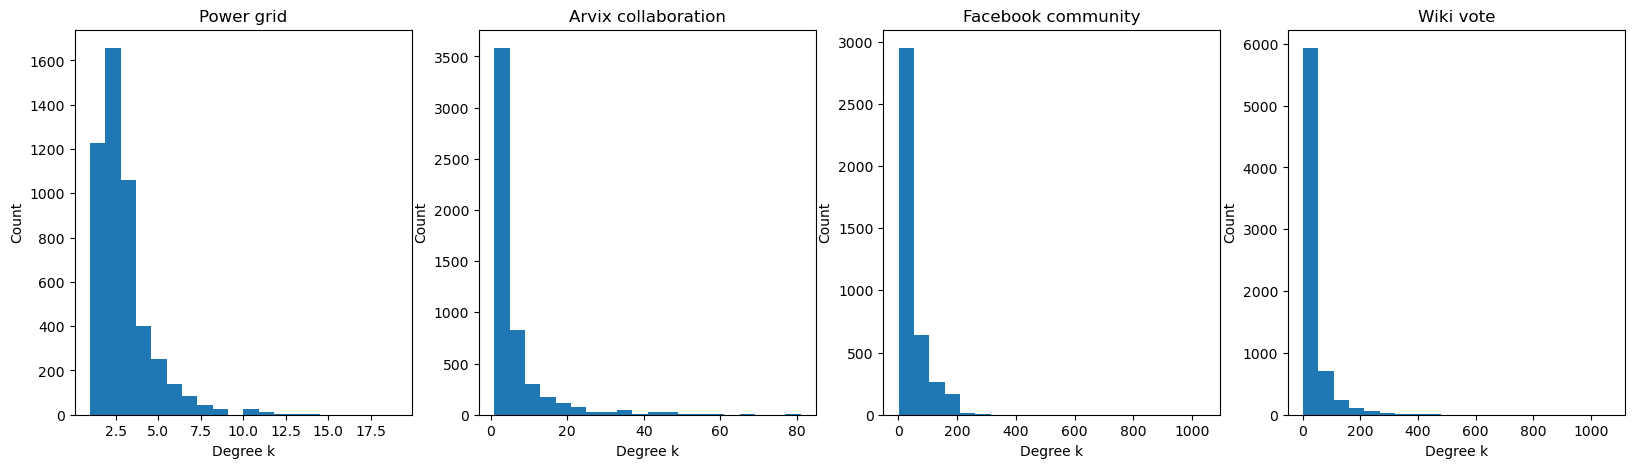

In [68]:
plt.figure(figsize=(4 * 5, 5))
real_graphs = [G_pgrid, G_arvix, G_fb, G_wiki]
titles = [
    "Power grid",
    "Arvix collaboration",
    "Facebook community",
    "Wiki vote",
]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, (G, title) in enumerate(zip(real_graphs, titles)):
    axs[i].set_title(title)
    axs[i].hist([G.degree(u) for u in G.nodes], bins=20)
    axs[i].set_xlabel("Degree k")
    axs[i].set_ylabel("Count")

plt.show()

# 経路（Path）

- 経路（path）とは、ノードとノードをエッジを通じてたどるノード列のことを指す。
- 経路が $(i_1, i_2, ..., i_k)$ のように $k$ 個のノードを通過する場合、長さ（length）は $k-1$。
- **単純経路（simple path）**：同じノードを2回以上通らない経路

- 最短経路とは、あるノードから別のノードへ到達する経路の中で、**通過するリンク（エッジ）の本数が最も少ないもの**を指す。
    - ノード $i$ からノード $j$ への最短経路の長さを $d(i, j)$ と表す
    - 有向ネットワークではエッジの向きを考慮する必要がある


- **平均最短経路長**（Average Shortest Path Length）：
  $$
  \langle d \rangle = \dfrac{1}{N(N - 1)} \sum_{i \neq j} d(i, j)
  $$
- **ネットワーク直径（diameter）**：
  全てのノード対 $(i, j)$ における最短距離の最大値：
  $$
  D = \max_{i, j} d(i, j)
  $$

最短経路 (1 → 6): [1, 5, 4, 6]
最短距離: 3
平均最短経路長: 1.7333333333333334
ネットワークの直径: 3


/tmp/ipykernel_71422/1851937310.py:29: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)


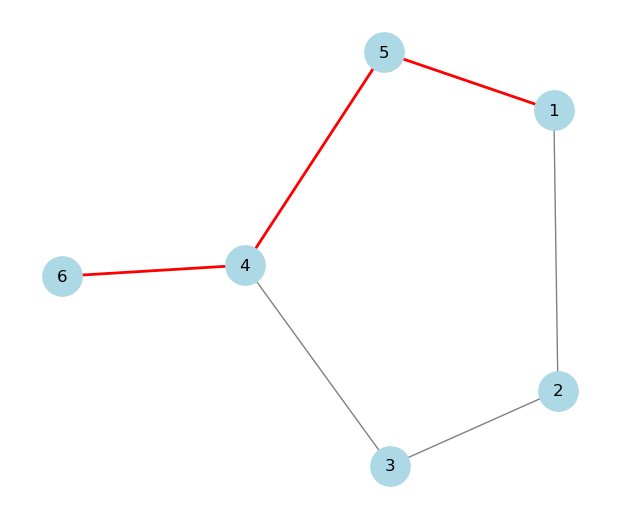

In [75]:
G = nx.Graph()
edges = [(1, 2), (2, 3), (3, 4), (1, 5), (5, 4), (4, 6)]
G.add_edges_from(edges)

# 最短経路（例：ノード1 → ノード6）
shortest_path = nx.shortest_path(G, source=1, target=6)
shortest_length = nx.shortest_path_length(G, source=1, target=6)

# 平均最短経路長（全ノード間）
avg_shortest_path = nx.average_shortest_path_length(G)

# ネットワークの直径
diameter = nx.diameter(G)

# 結果の出力
print("最短経路 (1 → 6):", shortest_path)
print("最短距離:", shortest_length)
print("平均最短経路長:", avg_shortest_path)
print("ネットワークの直径:", diameter)

# ネットワークの描画
plt.figure(figsize=(6, 5))
pos = nx.spring_layout(G, seed=42)

# 最短経路を赤で強調
path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))

nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

plt.show()

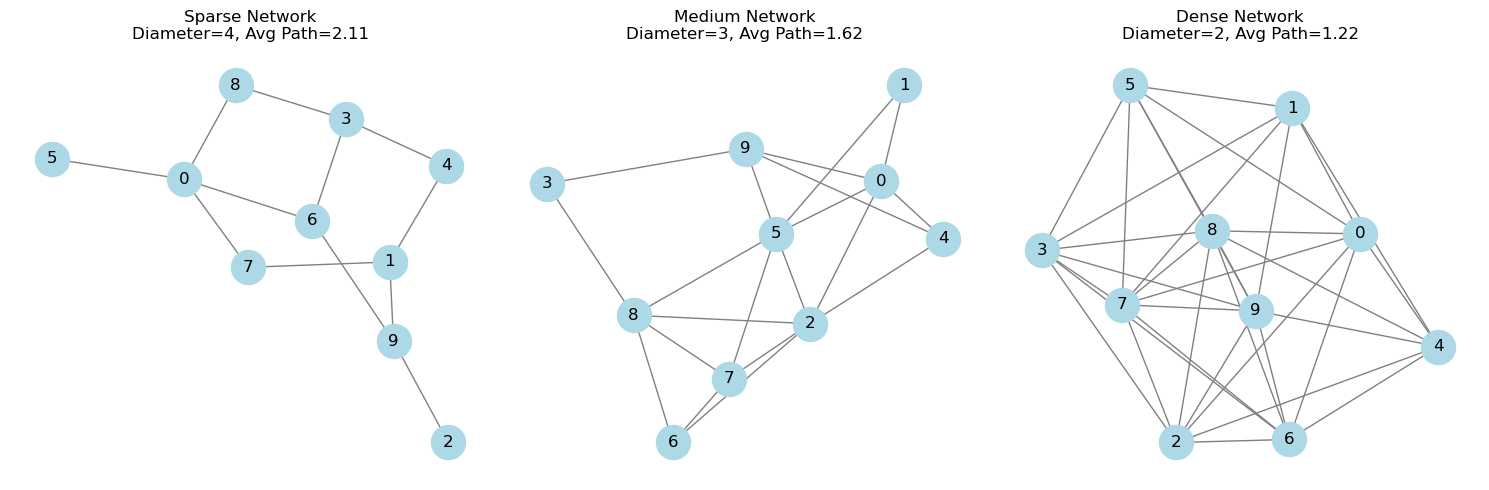

In [77]:
graphs = {}

graphs["Sparse"] = nx.gnm_random_graph(n=10, m=12, seed=1)

graphs["Medium"] = nx.gnm_random_graph(n=10, m=20, seed=2)

graphs["Dense"] = nx.gnm_random_graph(n=10, m=35, seed=3)

results = []

plt.figure(figsize=(15, 5))
for i, (name, G) in enumerate(graphs.items(), start=1):
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    avg_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    
    results.append({
        "Type": name,
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges(),
        "Avg Shortest Path": round(avg_path_length, 3),
        "Diameter": diameter
    })

    plt.subplot(1, 3, i)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=600)
    plt.title(f"{name} Network\nDiameter={diameter}, Avg Path={avg_path_length:.2f}")

plt.tight_layout()
plt.show()

# 連結性（Connectedness）

**連結性**とは、ネットワーク内のノード同士が**どれだけつながっているか**、つまり**一方のノードから他方のノードへ到達可能かどうか**を示す概念である。

- **連結グラフ（connected graph）**：
  - 任意のノード対 $(i, j)$ に対して、$i$ から $j$ までのパス（経路）が存在する。
- **非連結グラフ（disconnected graph）**：
  - ノードの一部が他と切り離されていて、すべてのノード間にパスが存在しない。


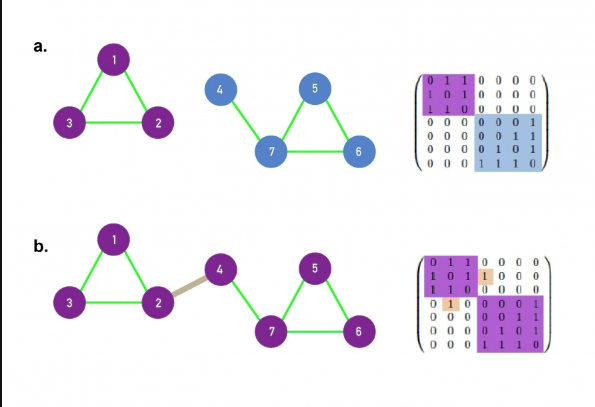


- **連結成分**とは、ネットワーク内で**互いに到達可能なノードの集合**。
    - 無向グラフでは、任意のノード対 $(i, j)$ に対してパスが存在すれば、同一の成分。
    - 有向グラフでは、以下の2種類の成分を区別：
        - **強連結成分（Strongly Connected Component）**
        - **弱連結成分（Weakly Connected Component）**

![Graph 4](https://koseki2580.github.io/study-docs/assets/images/graph-4.drawio-a7530706b59bdb922f19b1aa4ef19799.svg)


---

- **強連結（Strongly Connected）**  
  任意のノード対 $(i, j)$ に対して、  
  - ノード $i$ からノード $j$ へ到達するパスが存在し、同時にノード $j$ からノード $i$ へも到達できる場合、そのネットワーク（または成分）は **強連結** と呼ばれます。


---

- **弱連結（Weakly Connected）**  
  - 一方向しかパスが存在しないノード対がある場合、そのネットワークは **弱連結** です。


---

![Graph 4](https://miro.medium.com/v2/resize:fit:1400/1*2DtMg3xU5G_2Bvw8-hAxaQ.jpeg)


# クラスタリング係数（Clustering Coefficient）

クラスタリング係数は、ノードが密集する傾向があります。簡単に言えば、ノードの近隣ノードが互いにどの程度つながっているかを測定する。
- クラスタリング係数が高い場合、ノードの近隣ノードも互いにつながっており、緊密なコミュニティを形成していることを示す。逆に、クラスタリング係数が低い場合、近隣ノードのつながりが緩く、ネットワーク内の構造がよりランダムであることを示している可能性がある

$$
C_i = \dfrac{
\text{ノード } i \text{ の近隣同士の実際の接続数}
}{
\text{可能な最大接続数}
}
= \dfrac{2E_i}{k_i(k_i - 1)}
$$

- $E_i$：ノード $i$ の近隣ノード間に存在する**リンクの数**
- $k_i$：ノード $i$ の次数（隣接ノード数）
- 分母 $k_i(k_i - 1)/2$ は、近隣ノード間に張ることができる最大のエッジ数
- 値の範囲は $C_i \in [0, 1]$

In [85]:
def clustering_coef(G: nx.Graph, u: int):
    """
    Return the clustering coefficient of node `u` from graph `G`

    Parameters:
    -----------
    G: nx.Graph
        Input graph
    u: int
        Node to calculate the clustering coefficient of.

    Returns:
    --------
    clustering coeff: int

    """
    ei = 0
    for i in G.neighbors(u):  # For each neighbour `i` of `u`
        for j in G.neighbors(u):  # For each neighbour `j` of `u`
            if i != j:  # no self loops
                ei += G.has_edge(i, j)  # Check if it has edge and add it to the total edges
    return ei / (G.degree(u) * (G.degree(u) - 1))  # divide by 2 because we count the edges twice

<Figure size 1500x700 with 0 Axes>

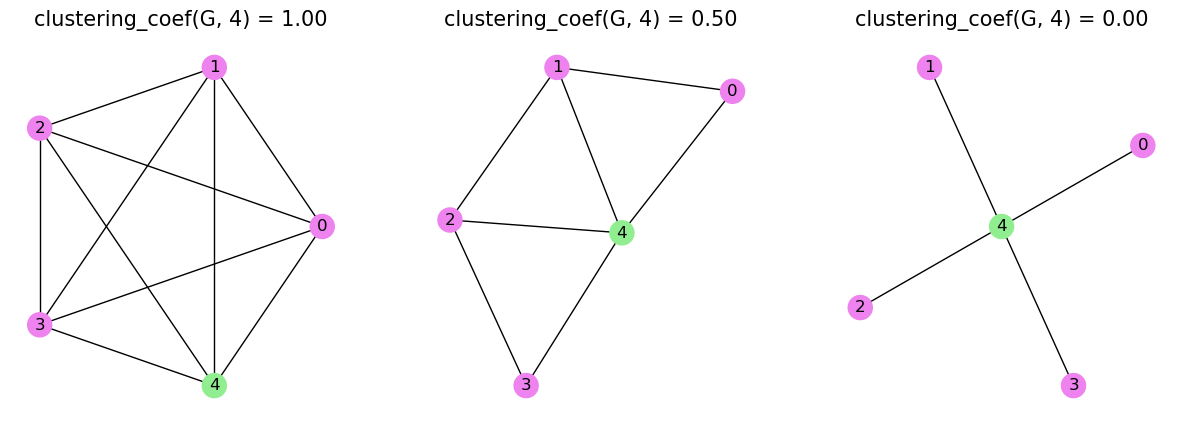

In [86]:
plt.figure(figsize=(15, 7))

G1 = nx.complete_graph(5)
G2 = nx.Graph([(0, 1), (0, 4), (1, 2), (1, 4), (2, 3), (2, 4), (3, 4)])
G3 = nx.Graph([(0, 4), (1, 4), (2, 4), (3, 4)])
graphs = [G1, G2, G3]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, G in enumerate(graphs):
    node_color = ["violet" if u != 4 else "lightgreen" for u in G.nodes]
    axs[i].set_title(f"{clustering_coef(G, 4) = :.2f}", size=15)
    nx.draw_kamada_kawai(G, with_labels=True, node_color=node_color, ax=axs[i])

- **平均クラスタリング係数**：

  $$
  C = \dfrac{1}{N} \sum_{i=1}^{N} C_i
  $$

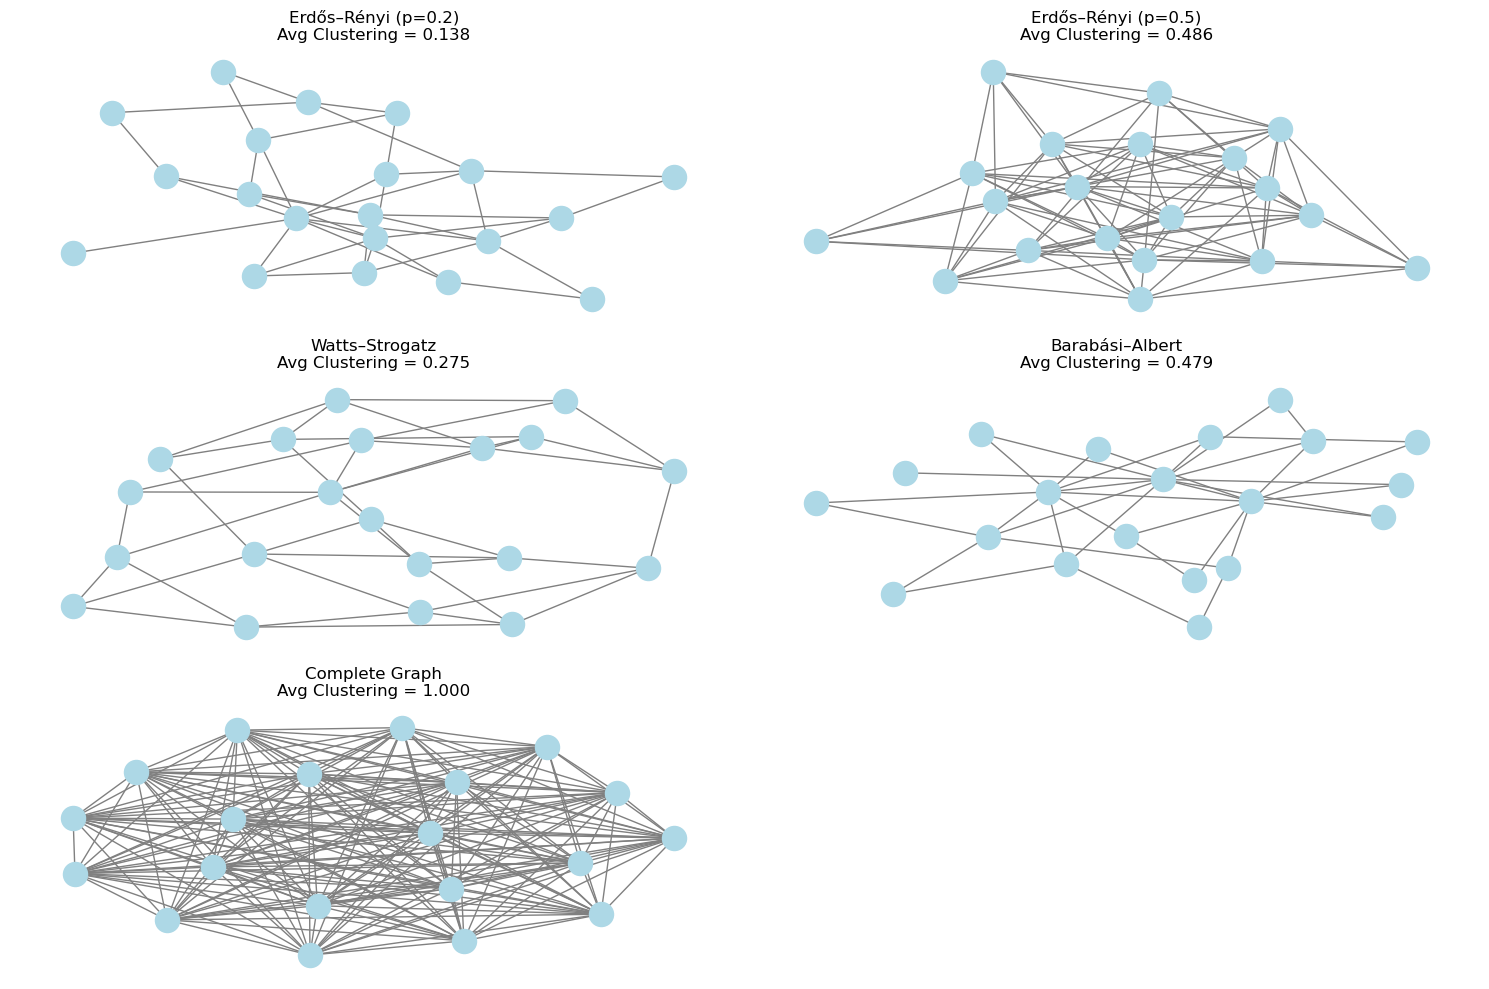

In [88]:
# ネットワークの種類を定義
graphs = {
    "Erdős–Rényi (p=0.2)": nx.erdos_renyi_graph(n=20, p=0.2, seed=1),
    "Erdős–Rényi (p=0.5)": nx.erdos_renyi_graph(n=20, p=0.5, seed=2),
    "Watts–Strogatz": nx.watts_strogatz_graph(n=20, k=4, p=0.3, seed=3),
    "Barabási–Albert": nx.barabasi_albert_graph(n=20, m=2, seed=4),
    "Complete Graph": nx.complete_graph(20)
}

# クラスタリング係数の集計
results = []
plt.figure(figsize=(15, 10))

for i, (name, G) in enumerate(graphs.items(), start=1):
    clustering = nx.average_clustering(G)
    results.append((name, clustering))

    # ネットワークの描画
    plt.subplot(3, 2, i)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=300)
    plt.title(f"{name}\nAvg Clustering = {clustering:.3f}")

plt.tight_layout()
plt.show()



# 中心性（Centralities）

ネットワークを構成する各ノードがそのネットワークの中でどれくらい重要であるかを示す指標である

<video width="640" height="360" controls>
  <source src="https://cambridge-intelligence.com/wp-content/uploads/2023/08/social-network-analysis-degree-centrality.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

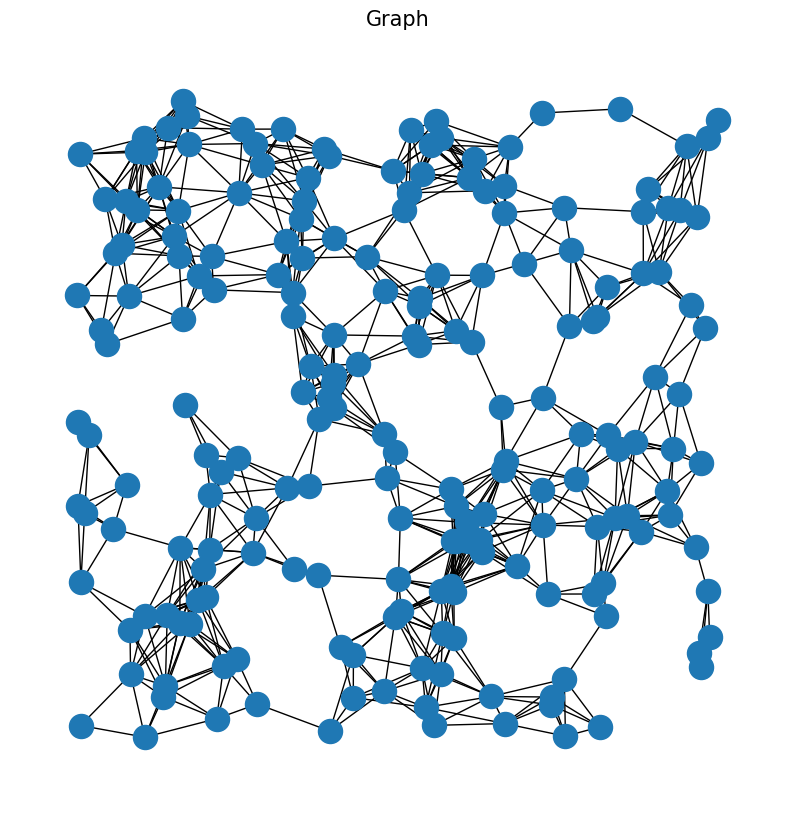

In [89]:
G = nx.random_geometric_graph(n=200, radius=0.125, seed=896803)  # 896803
pos = nx.get_node_attributes(G=G, name="pos")
plt.figure(figsize=(10, 10))
plt.title("Graph", size=15)
nx.draw(G, pos=pos)

## 次数中心性（Degree Centrality）

- ノードが直接つながっているリンク（エッジ）の数を元に、中心性を定義。
    - 多くのノードとつながっている＝影響力が大きい


$$
C_D(i) = \dfrac{\deg(i)}{N - 1}
$$

- $\deg(i)$：ノード $i$ の次数（隣接ノード数）
- $N$：ネットワークのノード総数

In [90]:
deg_colors = list(G.degree(n) for n in G.nodes)

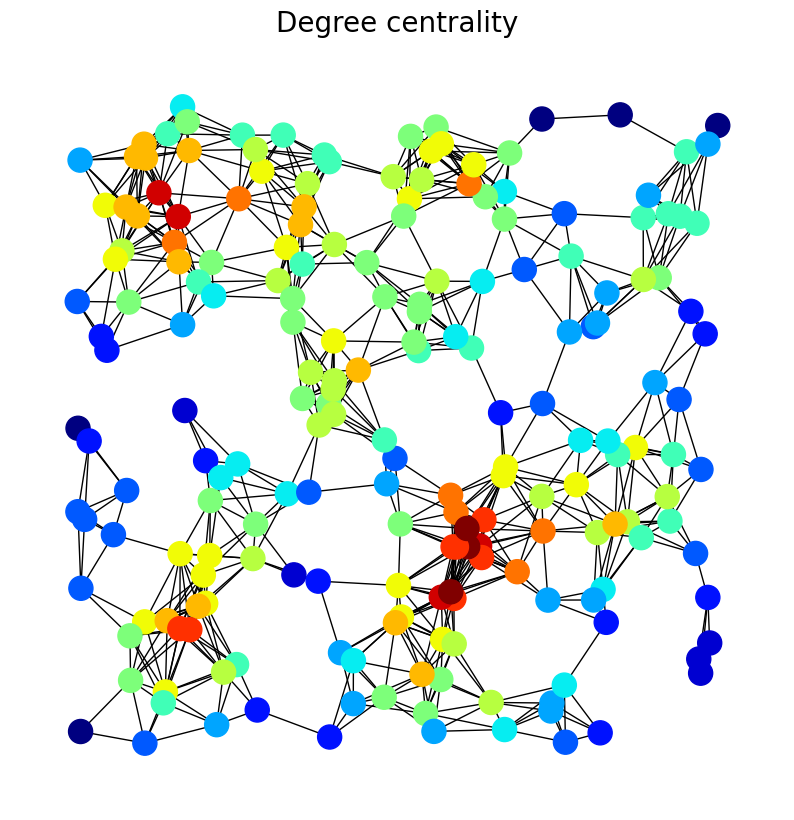

In [91]:
deg_colors = list(G.degree(n) for n in G.nodes)

plt.figure(figsize=(10, 10))
plt.title("Degree centrality", size=20)
nx.draw(G, pos=pos, node_color=deg_colors, cmap=plt.cm.jet)

## 媒介中心性（Betweenness Centrality）

- ノードが**他のノード対の最短経路の中間点**にどれだけ現れるかを測る。
    - 「情報の橋渡し役」「ネットワークの流れを制御するノード」

#### 数式：
$$
C_B(i) = \sum_{s \neq i \neq t} \dfrac{\sigma_{st}(i)}{\sigma_{st}}
$$

- $\sigma_{st}$：ノード $s$ から $t$ への最短経路の数  
- $\sigma_{st}(i)$：そのうちノード $i$ を通る経路の数


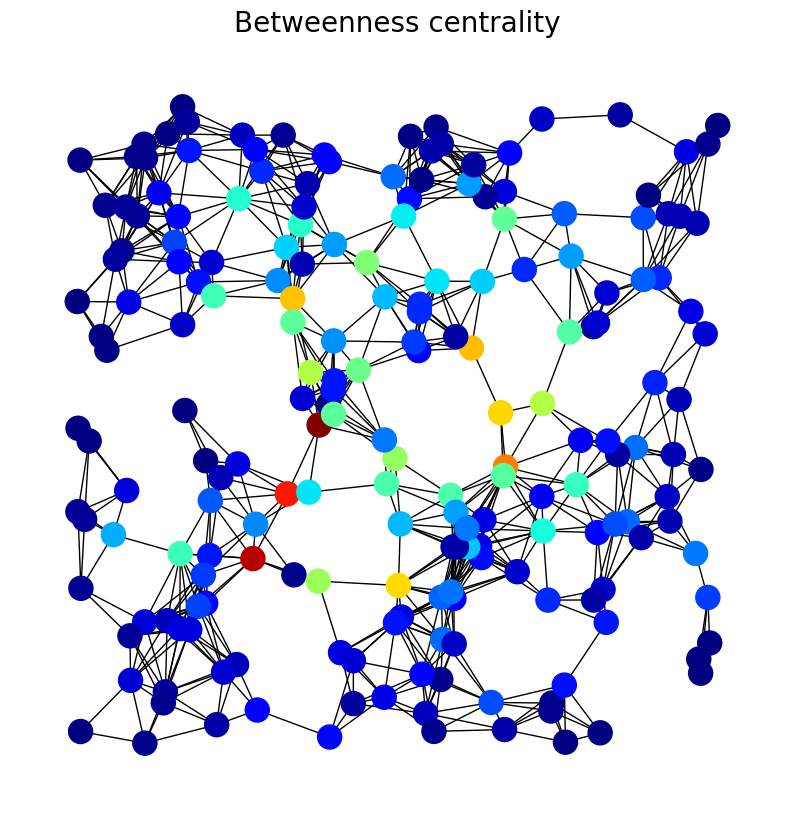

In [42]:
btw_colors = list(nx.betweenness_centrality(G).values())

plt.figure(figsize=(10, 10))
plt.title("Betweenness centrality", size=20)
nx.draw(G, pos=pos, node_color=btw_colors, cmap=plt.cm.jet)

## 近接中心性（Closeness Centrality）

- ノード $i$ から**他のすべてのノードまでの距離の逆数の合計**。
    - 他ノードに「素早く到達できる」中心的ノード。

#### 数式：
$$
C_C(i) = \dfrac{N - 1}{\sum_{j \neq i} d(i, j)}
$$

- $d(i, j)$：ノード $i$ と $j$ の間の最短距離


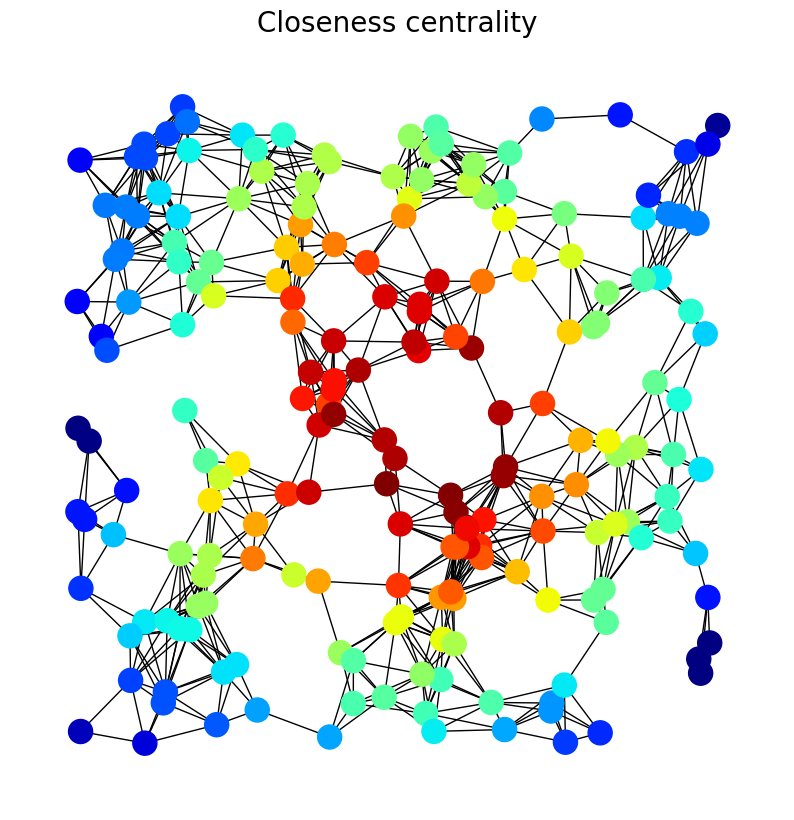

In [43]:
btw_colors = list(nx.closeness_centrality(G).values())

plt.figure(figsize=(10, 10))
plt.title("Closeness centrality", size=20)
nx.draw(G, pos=pos, node_color=btw_colors, cmap=plt.cm.jet)